#Agentic RAG (LangGraph)
Made by: Wilfredo Aaron Sosa Ramos

In [1]:
!pip install -U --quiet langchain-community tiktoken langchain-google-genai langchainhub chromadb langchain langgraph langchain-text-splitters

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.5 MB/s eta 0:00:00
 

In [3]:
!pip install -q arxiv pymupdf jq

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.6/746.6 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.2 MB/s eta 0:00:00


In [2]:
import os
from google.colab import userdata

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(var)

_set_env("GOOGLE_API_KEY")

In [8]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from functools import reduce
from typing import List
from langchain_community.document_loaders import ArxivLoader

#WEB
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=100
)
doc_splits = text_splitter.split_documents(docs_list)


#IMAGES
llm_for_img = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

def generate_docs_from_img(img_url, verbose: bool=False):
    message = HumanMessage(
    content=[
            {
                "type": "text",
                "text": "Give me a summary of what you see in the image. It must be 3 detailed paragraphs.",
            },
            {"type": "image_url", "image_url": img_url},
        ]
    )

    try:
        response = llm_for_img.invoke([message]).content
        print(f"Generated summary: {response}")
        docs = Document(page_content=response, metadata={"source": img_url})
        split_docs = text_splitter.split_documents([docs])
    except Exception as e:
        print(f"Error processing the request due to Invalid Content or Invalid Image URL")
        raise e

    return split_docs

def process_images_and_generate_docs(img_urls: List[str], verbose: bool = False):
    """
    Processes a list of image URLs to generate documents for each image
    and combines all documents into a single flat list.

    Args:
        img_urls (List[str]): List of image URLs to process.
        verbose (bool): Flag to enable verbose output for debugging.

    Returns:
        List[Document]: Combined list of all documents generated from images.
    """
    # Helper function for verbose printing
    verbose_print = lambda msg: print(msg) if verbose else None

    try:
        # Map `generate_docs_from_img` across the list of image URLs
        all_docs_lists = list(map(lambda img_url: generate_docs_from_img(img_url, verbose=verbose), img_urls))

        # Flatten the list of lists into a single list using `reduce`
        combined_docs = reduce(lambda acc, docs: acc + docs, all_docs_lists, [])

        verbose_print(f"Combined documents: {combined_docs}")
        return combined_docs
    except Exception as e:
        verbose_print(f"An error occurred: {e}")
        raise

image_urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/agent-overview.png",
    "https://promptengineering.org/content/images/2023/08/Prompt-engineering---Large-Language-Model-LLM--Autonomous-Agent-Structure---PromptEngineering.org.jpg",
    "https://cdn.prod.website-files.com/62528d398a42420e66390ef9/64df79e26db8eb0440ffc01d_HNIkPElHdpC1LtU3cRs2mgOfYuuauuJ0Sxdj7OsLafSTPd6_TFMFTc3VLNJjKrY9_849NUNsRdFnye-fp67B_aXmndJtAHwbMNysxXnAKOLIk7jGCXEF0ReXkt7euSvhK9VOjviBMjLIn9YT4oTgMnU.png"
]

# Process the images and get combined documents
img_docs = process_images_and_generate_docs(image_urls, verbose=True)

#ARXIV
# Supports all arguments of `ArxivAPIWrapper`
arxiv_loader = ArxivLoader(
    query="LLM Agents",
    load_max_docs=3,
)
arxiv_docs = arxiv_loader.load()
arxiv_docs_split = text_splitter.split_documents(arxiv_docs)

Generated summary: Certainly, here's a detailed summary of the image, broken into three paragraphs:

The image presents a flowchart or a conceptual diagram illustrating the architecture of an intelligent agent. At the core, a central "Agent" box, highlighted in a pinkish-red hue, is the focal point of the diagram. This agent is connected to several key components. It receives input from a "Memory" module, which is further divided into "Short-term memory" and "Long-term memory," indicating different storage durations for information. The agent also has access to a "Tools" module, which appears to be a collection of external functionalities, including a "Calendar()", "Calculator()", "CodeInterpreter()", "Search()", and an indication that more tools are available. The Agent also outputs to the "Action" box, implying the agent's actions are the end result.

The agent's decision-making process is further elaborated upon by its connection to a "Planning" module. This module suggests that the

In [9]:
print("WEB DOCS:")
print(doc_splits)
print(len(doc_splits))

WEB DOCS:
[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of 

In [10]:
print("IMAGES:")
print(doc_splits)
print(len(img_docs))

IMAGES:
[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of fi

In [11]:
print("ARXIV:")
print(arxiv_docs_split)
print(len(arxiv_docs_split))

ARXIV:
[Document(metadata={'Published': '2024-09-27', 'Title': 'Exploring Prosocial Irrationality for LLM Agents: A Social Cognition View', 'Authors': 'Xuan Liu, Jie Zhang, Song Guo, Haoyang Shang, Chengxu Yang, Quanyan Zhu', 'Summary': "Large language models (LLMs) have been shown to face hallucination issues due\nto the data they trained on often containing human bias; whether this is\nreflected in the decision-making process of LLM Agents remains under-explored.\nAs LLM Agents are increasingly employed in intricate social environments, a\npressing and natural question emerges: Can we utilize LLM Agents' systematic\nhallucinations to mirror human cognitive biases, thus exhibiting irrational\nsocial intelligence? In this paper, we probe the irrational behavior among\ncontemporary LLM Agents by melding practical social science experiments with\ntheoretical insights. Specifically, We propose CogMir, an open-ended Multi-LLM\nAgents framework that utilizes hallucination properties to asse

In [12]:
docs = doc_splits + img_docs + arxiv_docs_split
print(len(docs))

105


In [13]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=docs,
    collection_name="multimodal-rag",
    embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001"),
)
retriever = vectorstore.as_retriever()

In [14]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_information",
    "Search and return information about LLM Agents.",
)

tools = [retriever_tool]

In [15]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

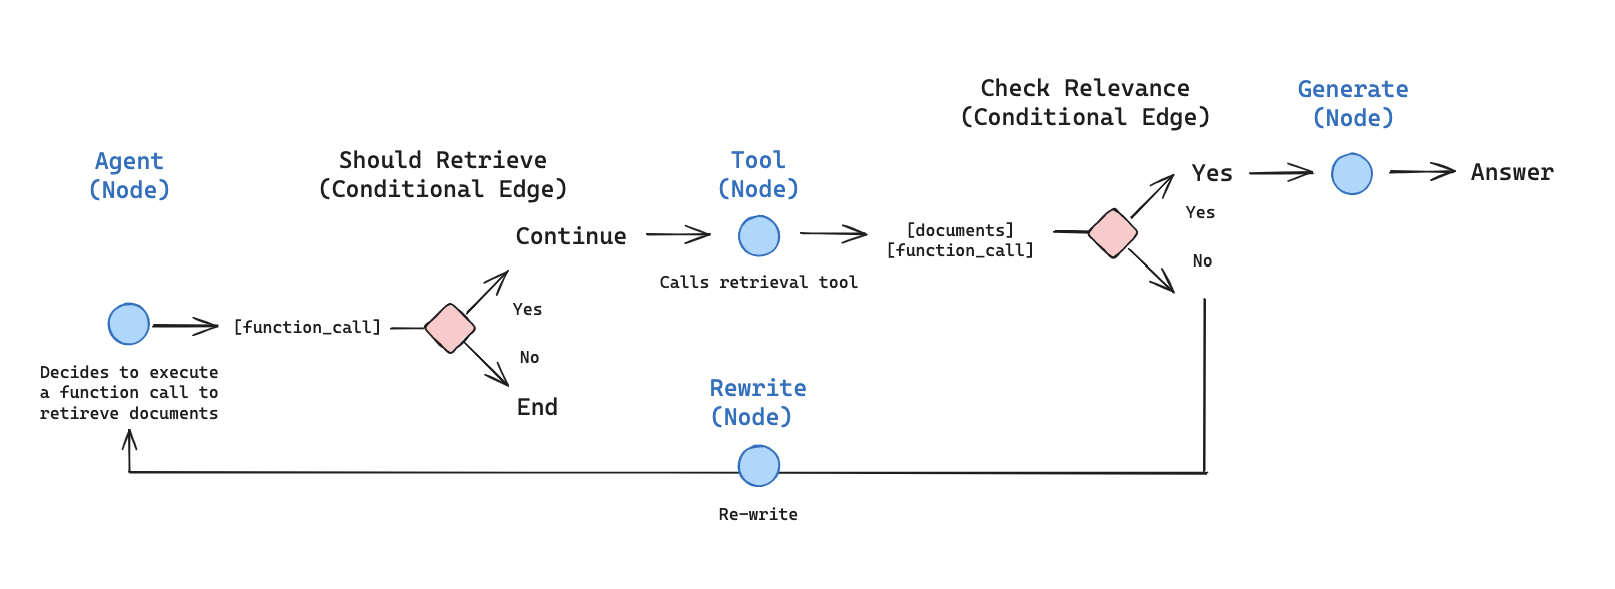

In [16]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.prebuilt import tools_condition

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
### Edges

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGoogleGenerativeAI(temperature=0, model="gemini-2.0-flash-exp", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [19]:
### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGoogleGenerativeAI(temperature=0, streaming=True, model="gemini-2.0-flash-exp")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGoogleGenerativeAI(temperature=0, model="gemini-2.0-flash-exp", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}

In [20]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [21]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

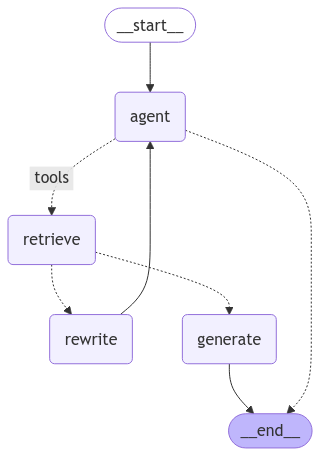

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
import pprint

inputs = {
    "messages": [
        ("user", "What are the LLM Agents?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'function_call': {'name': 'retrieve_information', 'arguments': '{"query": "What are the LLM Agents?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-c1cb95b3-c5c5-4d51-984a-aa78128b861d-0', tool_calls=[{'name': 'retrieve_information', 'args': {'query': 'What are the LLM Agents?'}, 'id': '3439cadb-39a5-49f2-9ade-2f1f565dc521', 'type': 'tool_call'}], usage_metadata={'input_tokens': 54, 'output_tokens': 11, 'total_tokens': 65, '

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'LLM Agents are systems that use large language models to '
                'interact with tools and perform tasks. They are provided with '
                'tool names, descriptions, and input/output details. The '
                'agents follow a specific format, such as ReAct, to reason and '
                'take actions using the tools.']}
'\n---\n'


In [24]:
import pprint

inputs = {
    "messages": [
        ("user", "What are the best practices for Memory in LLM Agents?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'function_call': {'name': 'retrieve_information', 'arguments': '{"query": "best practices for Memory in LLM Agents"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-4e4b0e5b-8d55-4489-932e-71a090fb2fca-0', tool_calls=[{'name': 'retrieve_information', 'args': {'query': 'best practices for Memory in LLM Agents'}, 'id': '0a082cca-0b2f-49d1-bf8d-c06f84fd5894', 'type': 'tool_call'}], usage_metadata={'input_tokens': 59, 'output_toke

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'Based on the provided text, best practices for memory in LLM '
                'agents involve understanding the limitations of finite '
                'context length and utilizing external vector stores for '
                'long-term memory.  These vector stores should support fast '
                'maximum inner-product search (MIPS) using approximate nearest '
                'neighbors (ANN) algorithms. Additionally, the text suggests '
                'that short-term memory is akin to in-context learning, '
                "limited by the transformer's context window."]}
'\n---\n'


In [25]:
import pprint

inputs = {
    "messages": [
        ("user", "Can you show me some LLM Architectures for Resilient Agents?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'function_call': {'name': 'retrieve_information', 'arguments': '{"query": "LLM Architectures for Resilient Agents"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-fd98eb4d-2afb-447a-910b-4e9ded0fd021-0', tool_calls=[{'name': 'retrieve_information', 'args': {'query': 'LLM Architectures for Resilient Agents'}, 'id': 'caf00ce6-9b6f-464c-a600-4105d80a2b9c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 61, 'output_tokens

In [26]:
import pprint

inputs = {
    "messages": [
        ("user", "What are some established or promising architectural patterns and design principles for building Large Language Model (LLM)-based agents that are robust, reliable, and can handle unexpected situations or errors gracefully?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'function_call': {'name': 'retrieve_information', 'arguments': '{"query": "architectural patterns and design principles for building robust and reliable LLM-based agents"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-65cedfd3-2b8a-415e-8495-cbf75a622d61-0', tool_calls=[{'name': 'retrieve_information', 'args': {'query': 'architectural patterns and design principles for building robust and reliable LLM-based agents'}, 'id': '

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'The provided text discusses challenges in building LLM-based '
                'agents, such as limited context length, difficulties in '
                'long-term planning, and the unreliability of natural language '
                'interfaces. However, it does not explicitly mention '
                'established or promising architectural patterns and design '
                'principles for building robust and reliable agents. '
                'Therefore, I cannot answer your question based on the given '
                'context.']}
'\n---\n'
